In [18]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as con
from tqdm import tqdm

In [19]:
df_all=pd.read_csv('../data/rv/TOI1696_rv_all.dat', sep=',')
df_yj=pd.read_csv('../data/rv/TOI1696_rv_yj.dat', sep=',')
df_yj

,bjd,rv,rv_err
0,2.459245e+06,-0.053392,0.01623
1,2.459488e+06,-0.029687,0.01424
2,2.459508e+06,0.068336,0.01874
3,2.459508e+06,0.061334,0.01405
4,2.459510e+06,0.105841,0.01895
5,2.459510e+06,0.045615,0.01487
6,2.459515e+06,-0.019704,0.01701
7,2.459515e+06,0.000000,0.01431
8,2.459531e+06,-0.046459,0.01720


In [3]:
df = df_all

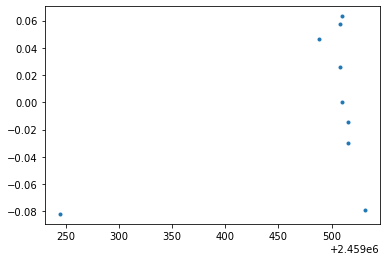

In [4]:
pl.plot(df['bjd'],df['rv'], '.')

In [5]:
T0 = 2459206.74743
P = 2.50079 #day
Ms = 0.261#solar mass
Mp = 68 #earth mass, tentative

a_rs = (0.023 * con.au/ (0.268 * con.R_sun)).value

b = 0.49
inc = np.arccos(b / a_rs)#rad

In [6]:
def rv_model_K(K, t0, p, tm):  
    rv = K* np.sin(2 * np.pi / p * (tm-t0))
    return rv
def rv_model_K_phase(K, ph):
    rv = K*np.sin(ph*np.pi*2)
    return rv

In [7]:
# 横軸phaseでplotするために

def phase(OBS_JD, T0, P):
    n = np.floor((OBS_JD-T0)/P)
    tr_before = T0 + n * P             #the JD of the last transit (phase=0) before the observation
    ph = (OBS_JD - tr_before)/P
    return ph

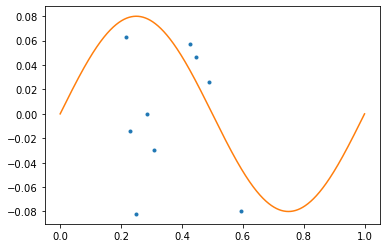

In [8]:
phase_obs = phase(df['bjd'], T0, P)
phase_pr = np.linspace(0,1,10000)

pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

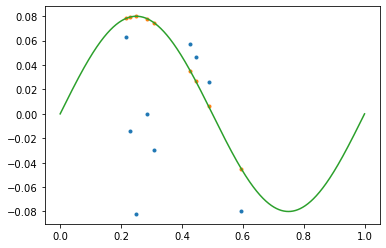

In [9]:
pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_obs, rv_model_K_phase(0.08, phase_obs), '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

In [10]:
pd.DataFrame({'phase':phase_obs, 'rv_obs':df['rv'], 'rv_model':rv_model_K_phase(0.08, phase_obs)})

,phase,rv_obs,rv_model
0,0.250090,-0.081987,0.080000
1,0.445876,0.046578,0.026684
2,0.427791,0.057321,0.035064
3,0.487738,0.025829,0.006157
4,0.217534,0.063226,0.078341
5,0.285627,0.000000,0.078004
6,0.229187,-0.014359,0.079317
7,0.308506,-0.029625,0.074655
8,0.595197,-0.079214,-0.045049


In [11]:
def logprob(K):
    rv_o = df['rv']
    rv_e = df['rv_err']
    rv_m = rv_model_K_phase(K, phase_obs)
    
    return -0.5 * np.sum(((rv_o - rv_m)/rv_e)**2)

In [12]:
import emcee

K=[0.05]

dim = 1
nwalkers = 100
nsteps=1000
pos0 = [K + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, dim, logprob)
sampler.run_mcmc(pos0, nsteps, progress=True)

100%|██████████| 1000/1000 [00:54<00:00, 18.88it/s]


State([[-5.91124584e-03]
 [ 2.46407022e-03]
 [ 3.32303941e-03]
 [ 2.84381512e-03]
 [ 9.93854603e-04]
 [ 1.77752911e-03]
 [-4.26946671e-03]
 [ 1.51012016e-03]
 [ 7.22346154e-03]
 [ 3.44561944e-03]
 [ 4.36607262e-04]
 [ 4.01657315e-03]
 [-4.88284530e-04]
 [-4.21992587e-03]
 [ 1.37822355e-03]
 [-5.53419097e-05]
 [ 2.28496117e-03]
 [ 1.77073642e-03]
 [ 8.56411093e-03]
 [ 3.88591122e-03]
 [ 1.66175180e-03]
 [ 2.39911744e-03]
 [ 5.60094245e-03]
 [-2.58485696e-03]
 [ 1.40447357e-03]
 [ 1.23014503e-03]
 [ 1.19486444e-04]
 [ 3.80148912e-03]
 [ 6.86939796e-03]
 [-1.98501688e-03]
 [ 1.43256813e-03]
 [ 4.93288680e-03]
 [-7.82071876e-04]
 [-1.60299454e-03]
 [ 4.34952415e-03]
 [-4.18133033e-04]
 [ 1.25344027e-04]
 [ 3.52387571e-03]
 [ 6.35058918e-03]
 [ 6.62437856e-04]
 [ 1.29906072e-03]
 [-1.02709747e-03]
 [ 1.06438456e-03]
 [-1.71674320e-03]
 [ 1.07025225e-03]
 [-1.02964265e-03]
 [ 2.85959362e-03]
 [-3.01639564e-03]
 [-3.27467251e-03]
 [ 5.92743978e-03]
 [-1.60030122e-03]
 [-1.15184904e-03]
 [ 9.4

In [13]:
sampler.chain[:,:].shape

(100, 1000, 1)

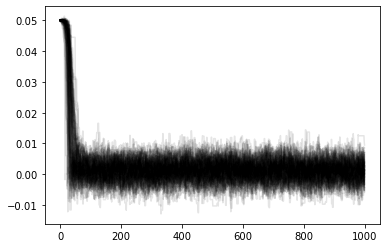

In [14]:
pl.plot(sampler.chain[:,:,0].T, color='k', alpha=0.1)

(array([3.000e+00, 1.000e+00, 6.000e+00, 1.000e+01, 2.400e+01, 4.800e+01,
        5.700e+01, 7.300e+01, 1.280e+02, 1.460e+02, 2.780e+02, 3.980e+02,
        5.110e+02, 7.840e+02, 9.440e+02, 1.339e+03, 1.754e+03, 2.088e+03,
        2.554e+03, 2.994e+03, 3.504e+03, 3.958e+03, 4.331e+03, 4.746e+03,
        4.882e+03, 5.023e+03, 5.139e+03, 4.990e+03, 4.520e+03, 4.410e+03,
        3.894e+03, 3.512e+03, 2.928e+03, 2.518e+03, 1.982e+03, 1.415e+03,
        1.223e+03, 9.260e+02, 6.540e+02, 4.990e+02, 2.630e+02, 1.950e+02,
        1.370e+02, 5.500e+01, 5.200e+01, 3.500e+01, 3.700e+01, 1.100e+01,
        1.600e+01, 5.000e+00]),
 array([-0.0128998 , -0.01235345, -0.01180709, -0.01126074, -0.01071439,
        -0.01016803, -0.00962168, -0.00907533, -0.00852897, -0.00798262,
        -0.00743627, -0.00688992, -0.00634356, -0.00579721, -0.00525086,
        -0.0047045 , -0.00415815, -0.0036118 , -0.00306544, -0.00251909,
        -0.00197274, -0.00142638, -0.00088003, -0.00033368,  0.00021268,
         0.

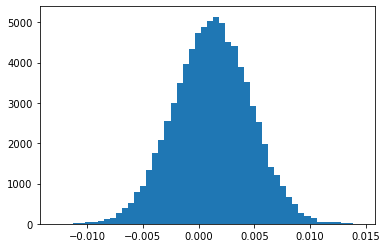

In [15]:
samples=sampler.chain[:,200:, :].reshape(-1)
df_chain= pd.DataFrame(samples)
pl.hist(samples, bins=50)

In [16]:
A,B,C,D,E=np.percentile(df_chain[0], [ 2.5, 16, 50, 84, 97.5], axis=0)
del1l =C-B   #1sigma
del1h=D-C
del2l=C-A   #2sigma
del2h=E-C 

best_K = C
best_K_err1=max(del1l,del1h)
best_K_err2=max(del2l,del2h)

print(best_K, best_K_err1, best_K_err2)

0.001242869195831613 0.003457210688355093 0.006790286009769997


収束判定まだしてないよ！

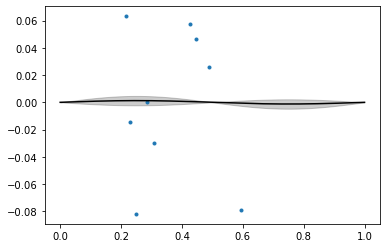

In [17]:
fig, ax = pl.subplots()

ax.plot(phase_obs, df['rv'], '.')

ax.plot(phase_pr, rv_model_K_phase(best_K, phase_pr), '-', color='k')

y1 = rv_model_K_phase(best_K+best_K_err1, phase_pr)
y2 = rv_model_K_phase(best_K-best_K_err1, phase_pr)

ax.fill_between(phase_pr, y1, y2, color='k', alpha=0.2)